# Final Project: 1C Company - Predict Future Sales

## Kaggle Competition

The final project for the "How to win a data science competition" Coursera course is to participate in a [Kaggle Competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales). In this competition we are going to work in a time-series challenge. We receive a dataset with information about the daily sales for a retail chain Russian software firm, and we need get the total sales for every product and every store in the next month.

Submissions are evaluated by **root mean squared error** (RMSE)

In [1]:
Validation = False
reduce_size = False
num_first_level_models = 3 
SEED = 0

import warnings
warnings.filterwarnings('ignore')
import time
import math
import pandas as pd
import numpy as np
import gc
from unidecode import unidecode
from tqdm import tqdm
from itertools import product
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import (LinearRegression, SGDRegressor)
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pickle
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 99)
pd.set_option('display.max_columns', 50)


# Data path
data_path = '../readonly/final_project_data'
submission_path = '.'

Using TensorFlow backend.


## 1. Load Data

We start loading the two main files, the sales and the test data files.

In [2]:
sale_train = pd.read_csv('%s/sales_train.csv.gz' % data_path)
test  = pd.read_csv('%s/test.csv.gz' % data_path)

We join the sales and the test set and dropt the duplicates. Finally we convert the date to a datetime format

In [3]:
test_nrow = test.shape[0]
sale_train = sale_train.merge(test[['shop_id']].drop_duplicates(), how = 'inner')
sale_train['date'] = pd.to_datetime(sale_train['date'], format = '%d.%m.%Y')

We are going to analyze the sales that the data provide us. For this, we analyze the item_cnt_day and the item_price and see the range of this features

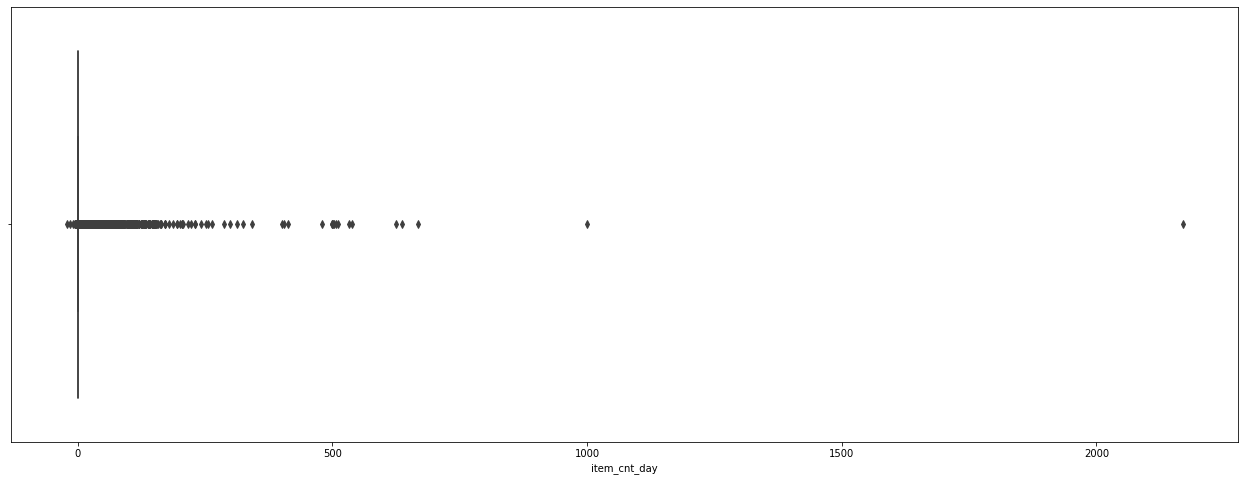

In [4]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sale_train['item_cnt_day'])
plt.show()

In [5]:
sale_train[sale_train['item_cnt_day'] >= 1000].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1123159,2015-01-15,24,12,20949,4.000000,1000.0
1133158,2015-10-28,33,12,11373,0.908714,2169.0


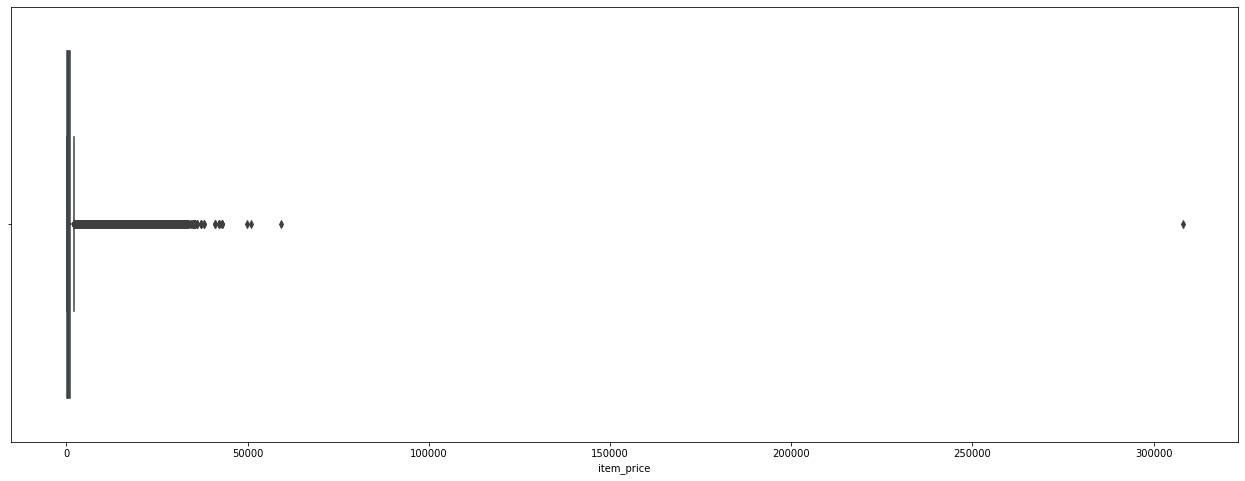

In [6]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sale_train['item_price'])
plt.show()

In [7]:
sale_train[sale_train['item_price'] > 300000].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1109451,2013-12-13,11,12,6066,307980.0,1.0


So we can see that we have outliers when the item_price > 300000 or when the item_cnt_day >= 1000, so we can delete these values

In [8]:
sale_train = sale_train[sale_train['item_cnt_day'] < 1000]
sale_train = sale_train[sale_train['item_price'] < 300000]

In [9]:
sale_train.head().T

,0,1,2,3,4
date,2013-01-02 00:00:00,2013-01-10 00:00:00,2013-01-04 00:00:00,2013-01-19 00:00:00,2013-01-31 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,22151,5603,5587,5613
item_price,999,399,699,199,5571
item_cnt_day,1,1,1,2,1


## 2. Feature Processing

### 2.1 Aggregate Data

We are going to create a grid for all shop/items combinations for Month

In [10]:
grid = []
for block_num in sale_train['date_block_num'].unique():
    cur_shops = sale_train[sale_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sale_train[sale_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [11]:
grid.head().T

,0,1,2,3,4
shop_id,59,59,59,59,59
item_id,22154,22151,5603,5587,5613
date_block_num,0,0,0,0,0


We are going to use downcast on Pandas to optimize the use of memory

In [12]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64", "int32"]]

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)

    return df

We convert the grid in a Panda Dataframe

In [13]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
sale_train['item_cnt_day'] = sale_train['item_cnt_day'].clip(0,20)
gb_cnt = sale_train.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
gb_cnt['item_cnt_month'] = gb_cnt['item_cnt_month'].clip(0,20).astype(np.int)

We merge the aggregated data to the grid

In [14]:
train = pd.merge(grid,gb_cnt,how='left',on=index_cols).fillna(0)
train['item_cnt_month'] = train['item_cnt_month'].astype(int)
train = downcast_dtypes(train)

And sort the data

In [15]:
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

We load the rest of the data from the csv files provided

In [16]:
item = pd.read_csv('%s/items.csv' % data_path)
train = train.merge(item[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
test = test.merge(item[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')

### 2.2 Text Processing

We have realized that the item_category_name is composed as **"generic category name + '-' + concrete category"**, so we are goint to process this field, generate the field and encoded it.

In [17]:
item_cat = pd.read_csv('%s/item_categories.csv' % data_path)
l_cat = item_cat.item_category_name.str.split('- | \(').map(lambda x: x[0]).map(lambda x: unidecode(x))

print(list(l_cat))

['PC ', 'Aksessuary ', 'Aksessuary ', 'Aksessuary ', 'Aksessuary ', 'Aksessuary ', 'Aksessuary ', 'Aksessuary ', 'Bilety', 'Dostavka tovara', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igrovye konsoli ', 'Igry ', 'Igry ', 'Igry ', 'Igry ', 'Igry ', 'Igry ', 'Igry ', 'Igry ', 'Igry Android ', 'Igry MAC ', 'Igry PC ', 'Igry PC ', 'Igry PC ', 'Igry PC ', 'Karty oplaty', 'Karty oplaty ', 'Karty oplaty ', 'Karty oplaty ', 'Karty oplaty ', 'Kino ', 'Kino ', 'Kino ', 'Kino ', 'Kino ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Knigi ', 'Muzyka ', 'Muzyka ', 'Muzyka ', 'Muzyka ', 'Muzyka ', 'Muzyka ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Podarki ', 'Programmy ', 'Programmy ', 'Programmy ', 'Programmy ', 'Programmy ', 'Programm

In [18]:
lb = preprocessing.LabelEncoder()
item_cat['item_cat_id_fix'] = lb.fit_transform(l_cat)

train = train.merge(item_cat[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')
test = test.merge(item_cat[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')

del item, item_cat, grid, gb_cnt
gc.collect()

4949

In [19]:
train.head().T

,0,1,2,3,4
shop_id,2,2,2,2,2
item_id,19,27,28,29,32
date_block_num,0,0,0,0,0
item_cnt_month,0,1,0,0,0
item_category_id,40,19,30,23,40
item_cat_id_fix,12,6,9,6,12


### 2.3 Add item/shop pairs with Mean Encoding  

We are going to Mean Encoding the Train Set using the methods that we have used during the course:
- KFold Scheme
- Leave One Out Scheme
- Smoothing Scheme
- Expanding Scheme

and finally, we use into our model the Mean Encoding method with the bigger value

In [20]:
start_time = time.time()
Target = 'item_cnt_month'
global_mean =  train[Target].mean()
y_tr = train[Target].values

mean_encoded_col = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix']
for col in tqdm(mean_encoded_col):
    col_tr = train[[col] + [Target]]
    corrcoefs = pd.DataFrame(columns = ['Cor'])
    
    # KFold Scheme
    kf = KFold(n_splits = 5, shuffle = False, random_state = SEED)

    col_tr[col + '_cnt_month_mean_Kfold'] = global_mean
    for tr_ind, val_ind in kf.split(col_tr):
        X_tr, X_val = col_tr.iloc[tr_ind], col_tr.iloc[val_ind]
        means = X_val[col].map(X_tr.groupby(col)[Target].mean())
        X_val[col + '_cnt_month_mean_Kfold'] = means
        col_tr.iloc[val_ind] = X_val
        # X_val.head()

    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_cnt_month_mean_Kfold'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Kfold'])[0][1]

    # Leave One Out Scheme
    item_id_target_sum = col_tr.groupby(col)[Target].sum()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_cnt_month_sum'] = col_tr[col].map(item_id_target_sum)
    col_tr[col + '_cnt_month_count'] = col_tr[col].map(item_id_target_count)
    col_tr[col + '_target_mean_LOO'] = (col_tr[col + '_cnt_month_sum'] - col_tr[Target]) / (col_tr[col + '_cnt_month_count'] - 1)
    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_target_mean_LOO'] = np.corrcoef(y_tr, col_tr[col + '_target_mean_LOO'])[0][1]

    # Smoothing Scheme
    item_id_target_mean = col_tr.groupby(col)[Target].mean()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_cnt_month_mean'] = col_tr[col].map(item_id_target_mean)
    col_tr[col + '_cnt_month_count'] = col_tr[col].map(item_id_target_count)
    alpha = 100
    col_tr[col + '_cnt_month_mean_Smooth'] = (col_tr[col + '_cnt_month_mean'] *  col_tr[col + '_cnt_month_count'] + global_mean * alpha) / (alpha + col_tr[col + '_cnt_month_count'])
    col_tr[col + '_cnt_month_mean_Smooth'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_cnt_month_mean_Smooth'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Smooth'])[0][1]

    # Expanding Scheme
    cumsum = col_tr.groupby(col)[Target].cumsum() - col_tr[Target]
    sumcnt = col_tr.groupby(col).cumcount()
    col_tr[col + '_cnt_month_mean_Expanding'] = cumsum / sumcnt
    col_tr[col + '_cnt_month_mean_Expanding'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_cnt_month_mean_Expanding'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Expanding'])[0][1]

    train = pd.concat([train, col_tr[corrcoefs['Cor'].idxmax()]], axis = 1)
    print(corrcoefs.sort_values('Cor'))
    print('%0.2f min: Finish encoding %s'%((time.time() - start_time)/60, col))

 25%|██▌       | 1/4 [00:21<01:04, 21.40s/it]

                                       Cor
shop_id_cnt_month_mean_Kfold      0.173375
shop_id_target_mean_LOO           0.175551
shop_id_cnt_month_mean_Smooth     0.175576
shop_id_cnt_month_mean_Expanding  0.175750
0.36 min: Finish encoding shop_id


 50%|█████     | 2/4 [00:47<00:45, 22.93s/it]

                                       Cor
item_id_cnt_month_mean_Kfold      0.315800
item_id_cnt_month_mean_Smooth     0.479793
item_id_target_mean_LOO           0.481889
item_id_cnt_month_mean_Expanding  0.565619
0.80 min: Finish encoding item_id


 75%|███████▌  | 3/4 [01:07<00:21, 21.94s/it]

                                                Cor
item_category_id_cnt_month_mean_Kfold      0.273997
item_category_id_cnt_month_mean_Smooth     0.292659
item_category_id_target_mean_LOO           0.292705
item_category_id_cnt_month_mean_Expanding  0.296038
1.13 min: Finish encoding item_category_id


100%|██████████| 4/4 [01:25<00:00, 21.41s/it]

                                               Cor
item_cat_id_fix_cnt_month_mean_Kfold      0.159015
item_cat_id_fix_target_mean_LOO           0.174418
item_cat_id_fix_cnt_month_mean_Smooth     0.174427
item_cat_id_fix_cnt_month_mean_Expanding  0.178152
1.43 min: Finish encoding item_cat_id_fix


In [21]:
train.head().T

,0,1,2,3,4
shop_id,2.000000,2.000000,2.000000,2.000000,2.000000
item_id,19.000000,27.000000,28.000000,29.000000,32.000000
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
item_cnt_month,0.000000,1.000000,0.000000,0.000000,0.000000
item_category_id,40.000000,19.000000,30.000000,23.000000,40.000000
item_cat_id_fix,12.000000,6.000000,9.000000,6.000000,12.000000
shop_id_cnt_month_mean_Expanding,0.310683,0.000000,0.500000,0.333333,0.250000
item_id_cnt_month_mean_Expanding,0.310683,0.310683,0.310683,0.310683,0.310683
item_category_id_cnt_month_mean_Expanding,0.310683,0.310683,0.310683,0.310683,0.000000
item_cat_id_fix_cnt_month_mean_Expanding,0.310683,0.310683,0.310683,1.000000,0.000000


## 3. EDA

We see the evolution of the target variable (item_cnt_month)

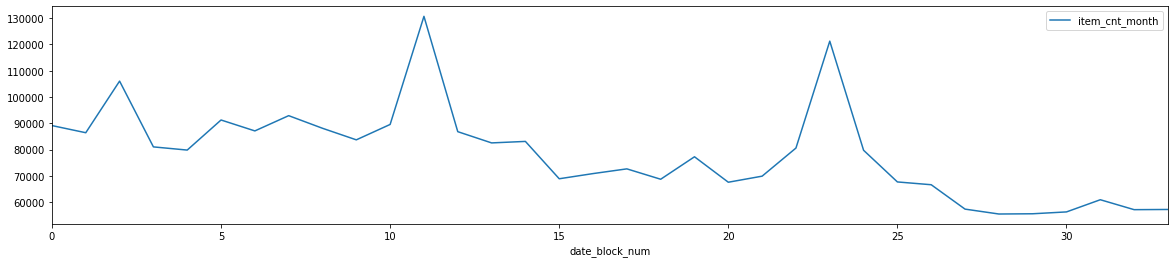

In [22]:
train.groupby('date_block_num').agg({'item_cnt_month':'sum'}).plot(figsize=(20,4))

We can represent the sales by shop_id

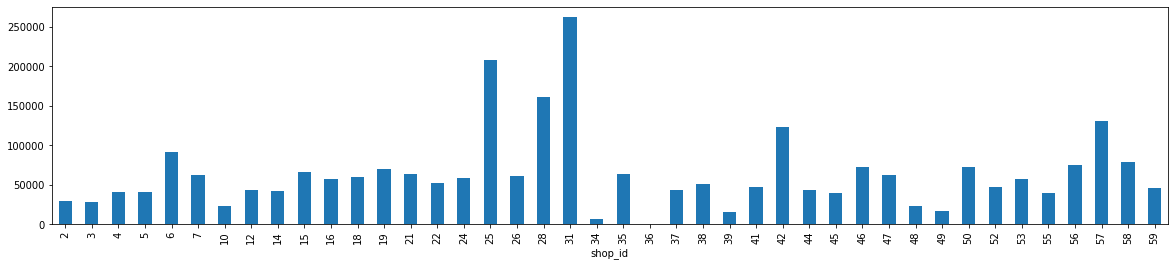

In [23]:
train.groupby("shop_id").sum()["item_cnt_month"].plot.bar(figsize=(20,4))

We can see the KDE distribution of item_cnt_month

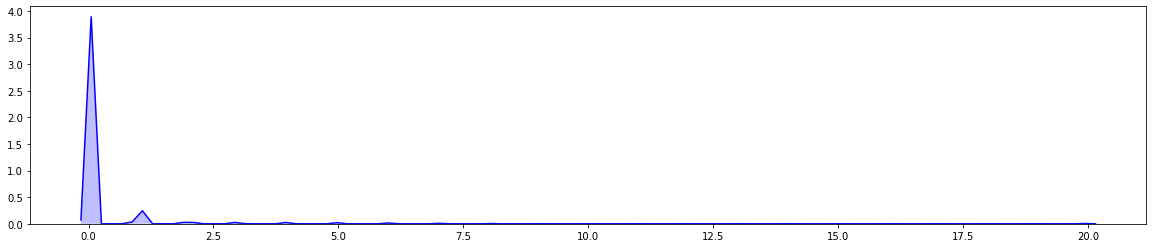

In [24]:
fig, ax = plt.subplots(figsize=(20,4))
sns.kdeplot(train['item_cnt_month'].values, shade=True, color='blue', ax=ax)
plt.show()

Next we show the evolution of the sales by item_categoy_id on time

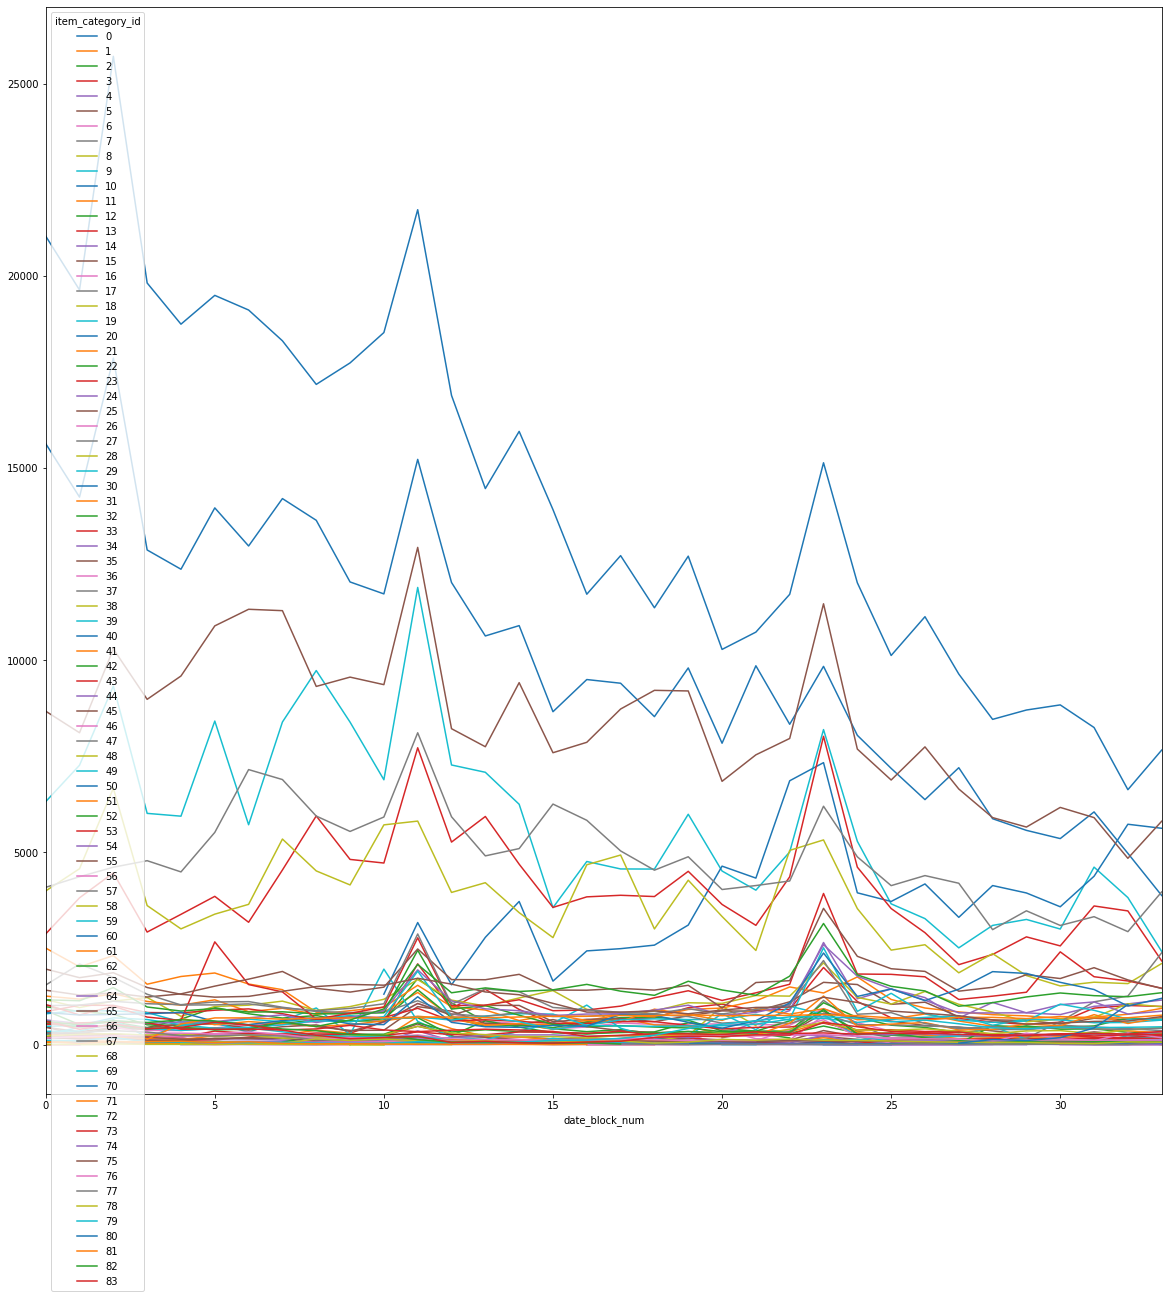

In [25]:
train.groupby(["date_block_num","item_category_id"]).sum()["item_cnt_month"].unstack().plot(figsize=(20,20))

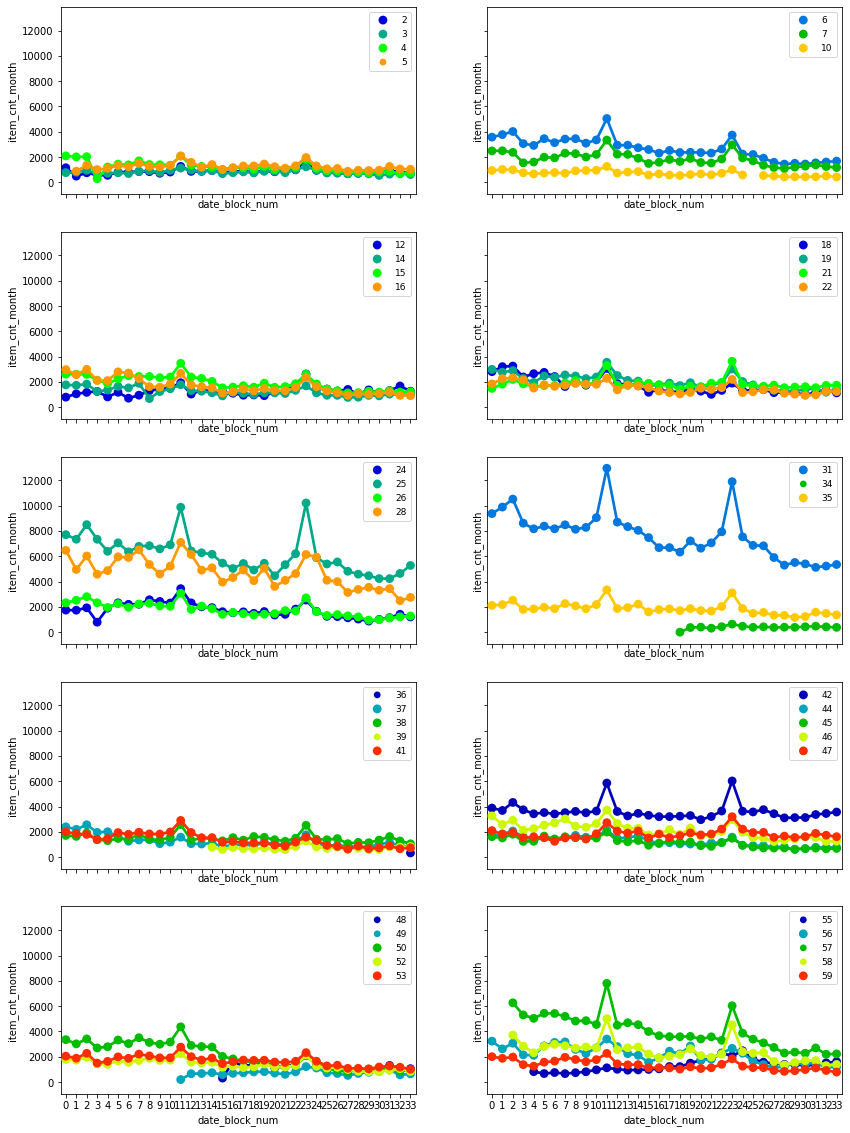

In [26]:
temp = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_month'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(14,20))
num_graph = 10
id_per_graph = math.ceil(temp.shop_id.max() / num_graph)
#fig.suptitle('Time series evolution of sales (per shop)')
x = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_month', hue='shop_id', palette='nipy_spectral',
                      data=temp[np.logical_and(x*id_per_graph <= temp['shop_id'],
                                               temp['shop_id'] < (x+1)*id_per_graph)],
                      ax=axes[i][j], grid=True, lw=1.0)
        axes[i,j].legend(loc='upper right')
        plt.setp(axes[i,j].get_legend().get_texts(), fontsize='9')
        plt.setp(axes[i,j].get_legend().get_title(), fontsize='10')
        x += 1

sns.reset_orig()

## 4. Feature Engineering 

### 4.1 Combine Train Set and Test Set

In [27]:
if Validation == False:
    test['date_block_num'] = 34
    all_data = pd.concat([train, test], axis = 0)
    all_data = all_data.drop(columns = ['ID'])
else:
    all_data = train

del train, test, col_tr
gc.collect()

all_data = downcast_dtypes(all_data)

### 4.2 Creating item/shop pairs lag based features

In [28]:
index_cols = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix', 'date_block_num']
cols_to_rename = list(all_data.columns.difference(index_cols))
print(cols_to_rename)
shift_range = [1, 2, 3, 4, 12]

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()

    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift
gc.collect()

all_data = all_data[all_data['date_block_num'] >= 12] # Don't use old data from year 2013
lag_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
all_data = downcast_dtypes(all_data)

  0%|          | 0/5 [00:00<?, ?it/s]

['item_cat_id_fix_cnt_month_mean_Expanding', 'item_category_id_cnt_month_mean_Expanding', 'item_cnt_month', 'item_id_cnt_month_mean_Expanding', 'shop_id_cnt_month_mean_Expanding']


100%|██████████| 5/5 [01:50<00:00, 22.00s/it]


### 4.3 Creating Date based features

In [29]:
dates_train = sale_train[['date', 'date_block_num']].drop_duplicates()
dates_test = dates_train[dates_train['date_block_num'] == 34-12]
dates_test['date_block_num'] = 34
dates_test['date'] = dates_test['date'] + pd.DateOffset(years=1)
dates_all = pd.concat([dates_train, dates_test])

dates_all['dow'] = dates_all['date'].dt.dayofweek
dates_all['year'] = dates_all['date'].dt.year
dates_all['month'] = dates_all['date'].dt.month
dates_all = pd.get_dummies(dates_all, columns=['dow'])
dow_col = ['dow_' + str(x) for x in range(7)]
date_features = dates_all.groupby(['year', 'month', 'date_block_num'])[dow_col].agg('sum').reset_index()
date_features['days_of_month'] = date_features[dow_col].sum(axis=1)
date_features['year'] = date_features['year'] - 2013

date_features = date_features[['month', 'year', 'days_of_month', 'date_block_num']]
all_data = all_data.merge(date_features, on = 'date_block_num', how = 'left')
date_columns = date_features.columns.difference(set(index_cols))

### 4.4 Scale Feature Columns

In [30]:
train = all_data[all_data['date_block_num']!= all_data['date_block_num'].max()]
test = all_data[all_data['date_block_num']== all_data['date_block_num'].max()]
sc = StandardScaler()

to_drop_cols = ['date_block_num']
feature_columns = list(set(lag_cols + index_cols + list(date_columns)).difference(to_drop_cols))

train[feature_columns] = sc.fit_transform(train[feature_columns])
test[feature_columns] = sc.transform(test[feature_columns])
all_data = pd.concat([train, test], axis = 0)
all_data = downcast_dtypes(all_data)

del train, test, date_features, sale_train
gc.collect()

0

In [31]:
all_data.head().T

,0,1,2,3,4
date_block_num,12.000000,12.000000,12.000000,12.000000,12.000000
item_cat_id_fix,-0.028603,-0.028603,-0.028603,-0.028603,-0.028603
item_cat_id_fix_cnt_month_mean_Expanding,0.240344,0.240344,0.240344,0.240344,0.240345
item_category_id,-0.303427,-0.493275,-0.303427,-0.493275,-0.303427
item_category_id_cnt_month_mean_Expanding,0.256568,0.207911,0.256568,0.207910,0.256569
item_cnt_month,0.000000,0.000000,1.000000,1.000000,0.000000
item_id,-1.784869,-1.784710,-1.784550,-1.784391,-1.784231
item_id_cnt_month_mean_Expanding,2.573201,1.821340,2.412844,0.793578,0.211009
shop_id,-1.651720,-1.651720,-1.651720,-1.651720,-1.651720
shop_id_cnt_month_mean_Expanding,0.104498,0.104497,0.104496,0.104505,0.104515


## 5. First Level Models

We are going to use three modes in the first level:
* SGDRegressor
* Lightgbm
* Neural Network


In [32]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts
dates = all_data['date_block_num']
last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)
print(feature_columns)

print('%0.2f min: Start training First level models'%((time.time() - start_time)/60))
start_first_level_total = time.perf_counter()

scoringMethod = 'r2'; 

# Train meta-features M = 15 (12 + 15 = 27)
months_to_generate_meta_features = range(27,last_block +1)
mask = dates.isin(months_to_generate_meta_features)
Target = 'item_cnt_month'
y_all_level2 = all_data[Target][mask].values
X_all_level2 = np.zeros([y_all_level2.shape[0], num_first_level_models])


# Now fill `X_train_level2` with metafeatures
slice_start = 0

for cur_block_num in tqdm(months_to_generate_meta_features):
    print('-' * 50)
    print('Start training for month %d'% cur_block_num)
    start_cur_month = time.perf_counter()

    cur_X_train = all_data.loc[dates <  cur_block_num][feature_columns]
    cur_X_test =  all_data.loc[dates == cur_block_num][feature_columns]

    cur_y_train = all_data.loc[dates <  cur_block_num, Target].values
    cur_y_test =  all_data.loc[dates == cur_block_num, Target].values

    # Create Numpy arrays of train, test and target dataframes to feed into models
    train_x = cur_X_train.values
    train_y = cur_y_train.ravel()
    test_x = cur_X_test.values
    test_y = cur_y_test.ravel()

    preds = []

    sgdr= SGDRegressor(
        penalty = 'l2' ,
        random_state = SEED )
    lgb_params = {
                  'feature_fraction': 0.75,
                  'metric': 'rmse',
                  'nthread':1,
                  'min_data_in_leaf': 2**7,
                  'bagging_fraction': 0.75,
                  'learning_rate': 0.03,
                  'objective': 'mse',
                  'bagging_seed': 2**7,
                  'num_leaves': 2**7,
                  'bagging_freq':1,
                  'verbose':0
                  }

    estimators = [sgdr]

    for estimator in estimators:
        print('Training Model %d: %s'%(len(preds), estimator.__class__.__name__))
        start = time.perf_counter()
        estimator.fit(train_x, train_y)
        pred_test = estimator.predict(test_x)
        preds.append(pred_test)
        # pred_train = estimator.predict(train_x)
        # print('Train RMSE for %s is %f' % (estimator.__class__.__name__, sqrt(mean_squared_error(cur_y_train, pred_train))))
        # print('Test RMSE for %s is %f' % (estimator.__class__.__name__, sqrt(mean_squared_error(cur_y_test, pred_test))))
        run = time.perf_counter() - start
        print('{} runs for {:.2f} seconds.'.format(estimator.__class__.__name__, run))
        print()

    print('Training Model %d: %s'%(len(preds), 'lightgbm'))
    start = time.perf_counter()
    estimator = lgb.train(lgb_params, lgb.Dataset(train_x, label=train_y), 300)
    pred_test = estimator.predict(test_x)
    preds.append(pred_test)
    # pred_train = estimator.predict(train_x)
    # print('Train RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(cur_y_train, pred_train))))
    # print('Test RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(cur_y_test, pred_test))))
    run = time.perf_counter() - start
    print('{} runs for {:.2f} seconds.'.format('lightgbm', run))
    print()

    print('Training Model %d: %s'%(len(preds), 'keras'))
    start = time.perf_counter()

    def baseline_model():
        # create model
        model = Sequential()
        model.add(Dense(20, input_dim=train_x.shape[1], kernel_initializer='uniform', activation='softplus'))
        model.add(Dense(1, kernel_initializer='uniform', activation = 'relu'))
        # Compile model
        model.compile(loss='mse', optimizer='Nadam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam')
        return model

    estimator = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=5, batch_size = 55000)

    estimator.fit(train_x, train_y)
    pred_test = estimator.predict(test_x)
    preds.append(pred_test)

    run = time.perf_counter() - start
    print('{} runs for {:.2f} seconds.'.format('keras', run))

    cur_month_run_total = time.perf_counter() - start_cur_month
    print('Total running time was {:.2f} minutes.'.format(cur_month_run_total/60))
    print('-' * 50)

    slice_end = slice_start + cur_X_test.shape[0]
    X_all_level2[ slice_start : slice_end , :] = np.c_[preds].transpose()
    slice_start = slice_end


Test `date_block_num` is 34
['item_cnt_month_lag_4', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_3', 'shop_id_cnt_month_mean_Expanding_lag_3', 'item_id_cnt_month_mean_Expanding_lag_4', 'item_category_id_cnt_month_mean_Expanding_lag_2', 'item_cnt_month_lag_2', 'month', 'item_cnt_month_lag_3', 'item_category_id', 'shop_id_cnt_month_mean_Expanding_lag_12', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_12', 'item_id_cnt_month_mean_Expanding_lag_1', 'days_of_month', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_2', 'item_id_cnt_month_mean_Expanding_lag_3', 'item_category_id_cnt_month_mean_Expanding_lag_12', 'item_category_id_cnt_month_mean_Expanding_lag_3', 'shop_id_cnt_month_mean_Expanding_lag_2', 'shop_id', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_4', 'item_id_cnt_month_mean_Expanding_lag_2', 'shop_id_cnt_month_mean_Expanding_lag_4', 'item_id_cnt_month_mean_Expanding_lag_12', 'year', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_1', 'shop_id_cnt_month_mean_Expanding_lag_1', 'item_c

  0%|          | 0/8 [00:00<?, ?it/s]

--------------------------------------------------
Start training for month 27
Training Model 0: SGDRegressor
SGDRegressor runs for 18.00 seconds.

Training Model 1: lightgbm
lightgbm runs for 197.38 seconds.

Training Model 2: keras

Epoch 1/5
3746814/3746814 [==============================] - 6s 1us/step - loss: 1.2465 - mse: 1.2465
Epoch 2/5
3746814/3746814 [==============================] - 5s 1us/step - loss: 0.9469 - mse: 0.9469
Epoch 3/5
3746814/3746814 [==============================] - 5s 1us/step - loss: 0.8915 - mse: 0.8915
Epoch 4/5
3746814/3746814 [==============================] - 5s 1us/step - loss: 0.8795 - mse: 0.8795
Epoch 5/5
221482/221482 [==============================] - 0s 0us/step


 12%|█▎        | 1/8 [04:04<28:33, 244.80s/it]

keras runs for 27.27 seconds.
Total running time was 4.08 minutes.
--------------------------------------------------
--------------------------------------------------
Start training for month 28
Training Model 0: SGDRegressor
SGDRegressor runs for 13.57 seconds.

Training Model 1: lightgbm
lightgbm runs for 206.25 seconds.

Training Model 2: keras
Epoch 1/5
3968296/3968296 [==============================] - 6s 1us/step - loss: 1.2168 - mse: 1.2168
Epoch 2/5
3968296/3968296 [==============================] - 5s 1us/step - loss: 0.9418 - mse: 0.9418
Epoch 3/5
3968296/3968296 [==============================] - 5s 1us/step - loss: 0.8964 - mse: 0.8964
Epoch 4/5
3968296/3968296 [==============================] - 5s 1us/step - loss: 0.8826 - mse: 0.8826
Epoch 5/5
212503/212503 [==============================] - 0s 1us/step


 25%|██▌       | 2/8 [08:14<24:36, 246.15s/it]

keras runs for 27.73 seconds.
Total running time was 4.15 minutes.
--------------------------------------------------
--------------------------------------------------
Start training for month 29
Training Model 0: SGDRegressor
SGDRegressor runs for 14.24 seconds.

Training Model 1: lightgbm
lightgbm runs for 216.82 seconds.

Training Model 2: keras
Epoch 1/5
4180799/4180799 [==============================] - 6s 1us/step - loss: 1.1933 - mse: 1.1933
Epoch 2/5
4180799/4180799 [==============================] - 6s 1us/step - loss: 0.9276 - mse: 0.9276
Epoch 3/5
4180799/4180799 [==============================] - 6s 1us/step - loss: 0.8892 - mse: 0.8892
Epoch 4/5
4180799/4180799 [==============================] - 6s 1us/step - loss: 0.8774 - mse: 0.8774
Epoch 5/5
210494/210494 [==============================] - 0s 0us/step


 38%|███▊      | 3/8 [12:37<20:56, 251.31s/it]

keras runs for 30.37 seconds.
Total running time was 4.39 minutes.
--------------------------------------------------
--------------------------------------------------
Start training for month 30
Training Model 0: SGDRegressor
SGDRegressor runs for 15.10 seconds.

Training Model 1: lightgbm
lightgbm runs for 262.90 seconds.

Training Model 2: keras
Epoch 1/5
4391293/4391293 [==============================] - 6s 1us/step - loss: 1.1602 - mse: 1.1602
Epoch 2/5
4391293/4391293 [==============================] - 6s 1us/step - loss: 0.9068 - mse: 0.9068
Epoch 3/5
4391293/4391293 [==============================] - 6s 1us/step - loss: 0.8722 - mse: 0.8722
Epoch 4/5
4391293/4391293 [==============================] - 7s 2us/step - loss: 0.8640 - mse: 0.8640
Epoch 5/5
215496/215496 [==============================] - 0s 1us/step
keras runs for 33.95 seconds.
Total running time was 5.23 minutes.
--------------------------------------------------


 50%|█████     | 4/8 [17:51<18:00, 270.08s/it]

--------------------------------------------------
Start training for month 31
Training Model 0: SGDRegressor
SGDRegressor runs for 17.53 seconds.

Training Model 1: lightgbm
lightgbm runs for 245.08 seconds.

Training Model 2: keras
Epoch 1/5
4606789/4606789 [==============================] - 7s 1us/step - loss: 1.1282 - mse: 1.1282
Epoch 2/5
4606789/4606789 [==============================] - 7s 1us/step - loss: 0.8850 - mse: 0.8850
Epoch 3/5
4606789/4606789 [==============================] - 7s 2us/step - loss: 0.8548 - mse: 0.8548
Epoch 4/5
4606789/4606789 [==============================] - 8s 2us/step - loss: 0.8481 - mse: 0.8481
Epoch 5/5
208444/208444 [==============================] - 0s 1us/step


 62%|██████▎   | 5/8 [22:52<13:58, 279.42s/it]

keras runs for 36.12 seconds.
Total running time was 5.02 minutes.
--------------------------------------------------
--------------------------------------------------
Start training for month 32
Training Model 0: SGDRegressor
SGDRegressor runs for 17.87 seconds.

Training Model 1: lightgbm
lightgbm runs for 269.15 seconds.

Training Model 2: keras
Epoch 1/5
4815233/4815233 [==============================] - 8s 2us/step - loss: 1.0960 - mse: 1.0960
Epoch 2/5
4815233/4815233 [==============================] - 7s 2us/step - loss: 0.8717 - mse: 0.8717
Epoch 3/5
4815233/4815233 [==============================] - 8s 2us/step - loss: 0.8455 - mse: 0.8455
Epoch 4/5
4815233/4815233 [==============================] - 8s 2us/step - loss: 0.8387 - mse: 0.8387
Epoch 5/5
208075/208075 [==============================] - 0s 1us/step
keras runs for 38.48 seconds.
Total running time was 5.47 minutes.
--------------------------------------------------


 75%|███████▌  | 6/8 [28:20<09:48, 294.04s/it]

--------------------------------------------------
Start training for month 33
Training Model 0: SGDRegressor
SGDRegressor runs for 19.02 seconds.

Training Model 1: lightgbm
lightgbm runs for 288.16 seconds.

Training Model 2: keras
Epoch 1/5
5023308/5023308 [==============================] - 8s 2us/step - loss: 1.1059 - mse: 1.1059
Epoch 2/5
5023308/5023308 [==============================] - 8s 2us/step - loss: 0.8743 - mse: 0.8743
Epoch 3/5
5023308/5023308 [==============================] - 8s 2us/step - loss: 0.8461 - mse: 0.8461
Epoch 4/5
5023308/5023308 [==============================] - 8s 2us/step - loss: 0.8397 - mse: 0.8397
Epoch 5/5
221802/221802 [==============================] - 0s 1us/step


 88%|████████▊ | 7/8 [34:09<05:10, 310.59s/it]

keras runs for 39.59 seconds.
Total running time was 5.82 minutes.
--------------------------------------------------
--------------------------------------------------
Start training for month 34
Training Model 0: SGDRegressor
SGDRegressor runs for 19.22 seconds.

Training Model 1: lightgbm
lightgbm runs for 276.17 seconds.

Training Model 2: keras
Epoch 1/5
5245110/5245110 [==============================] - 8s 2us/step - loss: 1.0921 - mse: 1.0921
Epoch 2/5
5245110/5245110 [==============================] - 8s 1us/step - loss: 0.8742 - mse: 0.8742
Epoch 3/5
5245110/5245110 [==============================] - 8s 1us/step - loss: 0.8491 - mse: 0.8491
Epoch 4/5
5245110/5245110 [==============================] - 8s 1us/step - loss: 0.8406 - mse: 0.8406
Epoch 5/5
214200/214200 [==============================] - 0s 1us/step


100%|██████████| 8/8 [39:48<00:00, 298.51s/it]

keras runs for 40.20 seconds.
Total running time was 5.64 minutes.
--------------------------------------------------


We split train and test

In [33]:
test_nrow = len(preds[0])
X_train_level2 = X_all_level2[ : -test_nrow, :]
X_test_level2 = X_all_level2[ -test_nrow: , :]
y_train_level2 = y_all_level2[ : -test_nrow]
y_test_level2 = y_all_level2[ -test_nrow : ]

39.80 min: Finish training First level models


## 6. Ensemble

We are going to use two models for our Ensamble:
* Linear Regression
* SGDRegressor

### 6.1 Ensemble 1: Linear Regression

In [34]:
pred_list = {}
print('Training Second level learning model via linear regression')

lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)
# Compute R-squared on the train and test sets.
test_preds_lr_stacking = lr.predict(X_test_level2)
train_preds_lr_stacking = lr.predict(X_train_level2)
print('Train R-squared for %s is %f' %('train_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, train_preds_lr_stacking))))

pred_list['test_preds_lr_stacking'] = test_preds_lr_stacking
if Validation:
    print('Test R-squared for %s is %f' %('test_preds_lr_stacking', sqrt(mean_squared_error(y_test_level2, test_preds_lr_stacking))))

Training Second level learning model via linear regression
Train R-squared for train_preds_lr_stacking is 0.816605


### 6.2 Ensemble 2: SGDRegressor

In [35]:
print('Training Second level learning model via SGDRegressor')
sgdr= SGDRegressor(
    penalty = 'l2' ,
    random_state = SEED )

sgdr.fit(X_train_level2, y_train_level2)
# Compute R-squared on the train and test sets.
test_preds_sgdr_stacking = sgdr.predict(X_test_level2)
train_preds_sgdr_stacking = sgdr.predict(X_train_level2)
print('Train R-squared for %s is %f' %('train_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, train_preds_sgdr_stacking))))

pred_list['test_preds_sgdr_stacking'] = test_preds_sgdr_stacking
if Validation:
    print('Test R-squared for %s is %f' %('test_preds_sgdr_stacking', sqrt(mean_squared_error(y_test_level2, test_preds_sgdr_stacking))))

Training Second level learning model via SGDRegressor
Train R-squared for train_preds_lr_stacking is 0.816656


## Submission

In [36]:
submission = pd.read_csv('%s/sample_submission.csv.gz' % data_path)
ver = 2

for pred_ver in ['lr_stacking', 'sgdr_stacking']:
    print(pred_list['test_preds_' + pred_ver].clip(0,20).mean())
    submission['item_cnt_month'] = pred_list['test_preds_' + pred_ver].clip(0,20)
    submission[['ID', 'item_cnt_month']].to_csv('%s/ver%d_%s.csv' % (submission_path, ver, pred_ver), index = False)

0.29658239777263384
0.2994766990264633
